In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pyreadr
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import Normalize
import cmcrameri 
import seaborn as sns
import xarray as xr
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from evaluation.metrics import *

# Define colors and parameters

In [2]:
path = "../../plots/"
plot_path = "../plots/data/"

In [3]:
plt.style.use('seaborn-v0_8')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

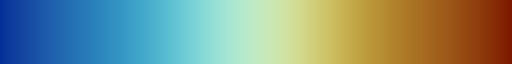

In [4]:
cmap

In [5]:
ticksize = 20
fontsize = 28
axsize = 25
legendsize = 20
titlesize = 30
lw = 2.5

## Sizes

In [6]:
single_1 = (20,8)

# Plot GEV

In [7]:
gen = scipy.stats.genextreme
x = np.linspace(-3,5,1000)

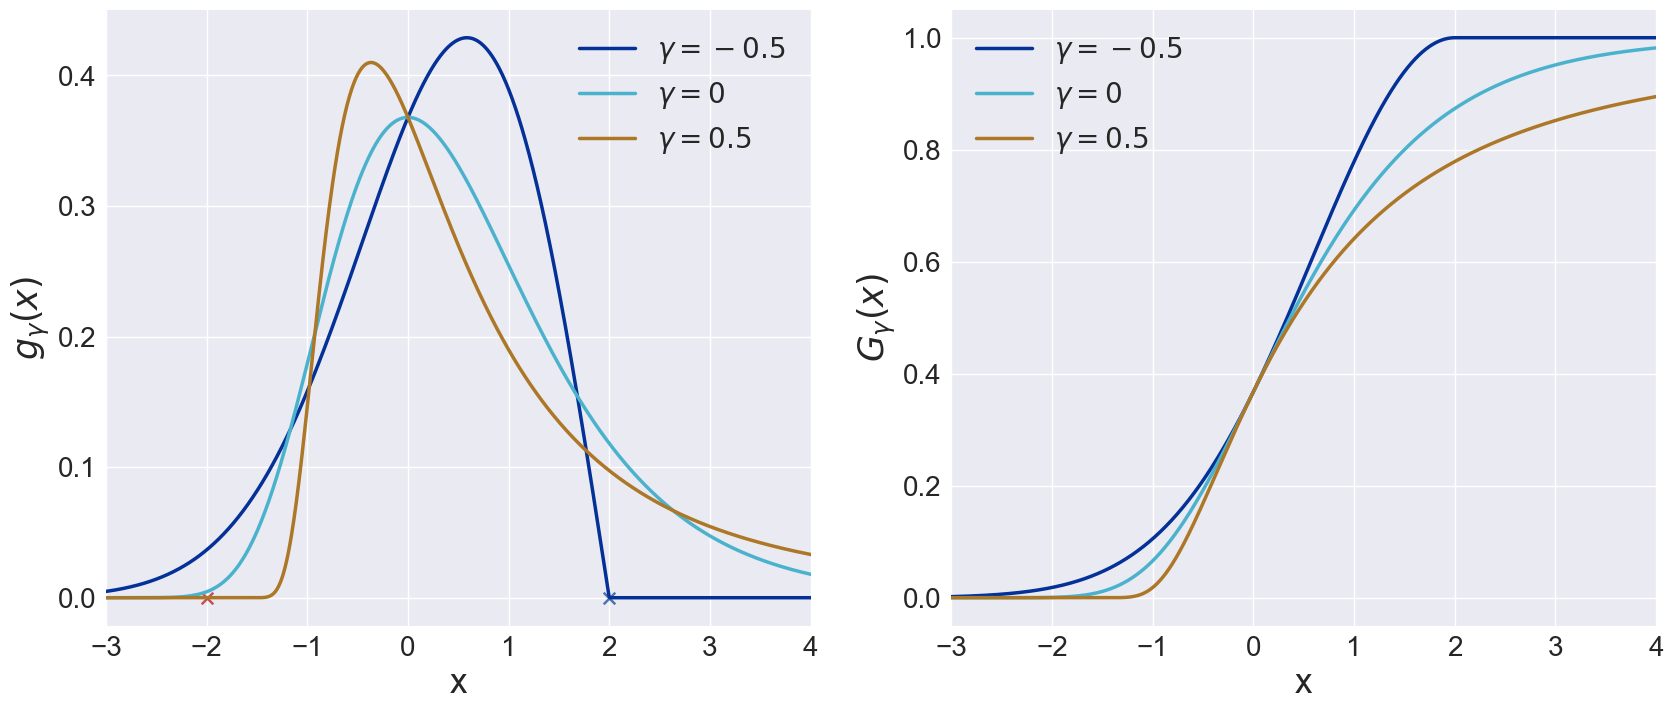

In [11]:
fig, axs = plt.subplots(1,2, figsize = single_1)
colors = [cmap(x) for x in [0,0.3,0.8]]

for i,c in enumerate([-0.5,0,0.5]):
    y = gen.pdf(x, -c)
    #y[y == 0] = np.nan
    y2 = gen.cdf(x, -c)
    axs[0].plot(x, y, label = fr'$\gamma = {c}$', color = colors[i], lw = lw)
    axs[1].plot(x, y2, label = fr'$\gamma = {c}$', color = colors[i], lw = lw)

axs[0].scatter(2, 0, marker = "x", s = 70)
axs[0].scatter(-7,0)
axs[0].scatter(-2, 0, marker = "x", s = 70)


axs[0].set_xlim([-3,4])    
axs[0].set_xlabel("x", fontsize = axsize)
axs[0].set_ylabel(r"$g_\gamma(x)$", fontsize = axsize)
axs[0].legend(fontsize = legendsize)
axs[0].tick_params(axis='both', labelsize=ticksize)

axs[1].set_xlim([-3,4])    
axs[1].set_xlabel("x", fontsize = axsize)
axs[1].set_ylabel(r"$G_\gamma(x)$", fontsize = axsize)
axs[1].legend(fontsize = legendsize)
axs[1].tick_params(axis='both', labelsize=ticksize)

plt.savefig(path +"gev_example.pdf", bbox_inches = "tight")

# Plot max-stable simulation

In [12]:
def corr_func(h, r = 1.5, s = 0.5):
    res = np.exp(-np.power((h/r),s))
    return res    

In [13]:
def gaussian_process(n, left = -2, right = 2):    
    x = np.expand_dims(np.linspace(-2, 2, n), 1)
    sigma = corr_func(scipy.spatial.distance.cdist(x, x, 'sqeuclidean'))

    # Draw samples from the prior at our data points.
    # Assume a mean of 0 for simplicity
    ys = np.random.multivariate_normal(
        mean=np.zeros(n), cov=sigma, 
        size=1)
    return np.squeeze(ys)

In [14]:
def y_i(n = 100, left = -2, right = 2):
    eps = gaussian_process(n, left, right)
    eps[eps < 0] = 0
    y = np.sqrt(2 * np.pi) * eps
    return y    

In [22]:
n_sim = 50
n = 250
x = np.linspace(-1, 1, n)

In [23]:
points = np.zeros(n_sim)
processes = np.zeros((n_sim, n))
s = 0
c = 3

for sim in range(n_sim):
    s = s + np.random.exponential(1)
    points[sim] = 1/s
    processes[sim] = y_i(n)
    scaled_processes = np.expand_dims(points, 1) * processes
    max_process = np.max(scaled_processes, axis = 0)
    if points[sim]* c < np.min(max_process):
        break

In [24]:
# Define outcome
sorted_points = -np.sort(-points)
scaled_processes = np.expand_dims(points, 1) * processes
max_process = np.max(scaled_processes, axis = 0)

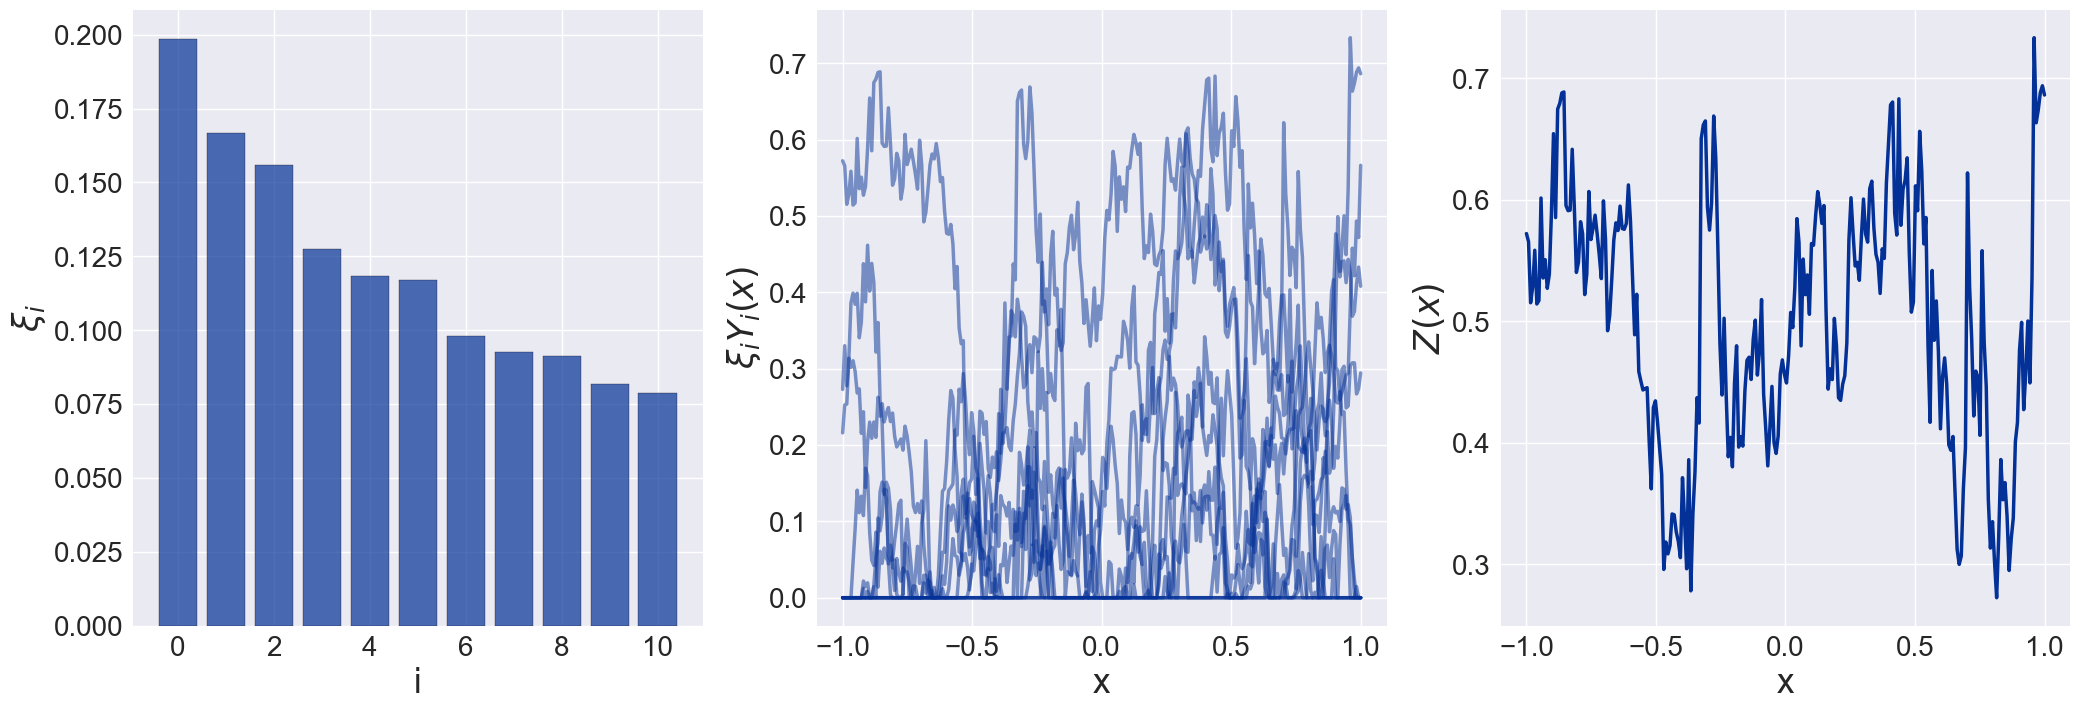

In [25]:
#Plot
fig, axs = plt.subplots(1, 3, figsize = (25,8))
colors = [cmap(0)]

axs[0].bar(np.arange(0, sim), sorted_points[0:sim], alpha = 0.7, edgecolor = "black", color = colors[0])
axs[2].plot(x, max_process, color = colors[0], lw = lw)
for i in range(sim):
    axs[1].plot(x, scaled_processes[i], alpha = 0.5, color = colors[0], lw = lw)


#Legend
axs[0].set_xlabel("i", fontsize = axsize)
axs[0].set_ylabel(r"$\xi_i$", fontsize = axsize)

axs[1].set_xlabel("x", fontsize = axsize)
axs[1].set_ylabel(r"$\xi_i Y_i(x)$", fontsize = axsize)

axs[2].set_xlabel("x", fontsize = axsize)
axs[2].set_ylabel(r"$Z(x)$", fontsize = axsize)

for ax in range(3):
    axs[ax].tick_params(axis='both', labelsize=ticksize)

plt.savefig(path +"max_stable_simulation.pdf", bbox_inches = "tight")

# Plot max-stable processes

In [57]:
model = "brown"

example_params = pyreadr.read_r(plot_path+model+"_example_params.RData")["train_params"].to_numpy()
example_data = pyreadr.read_r(plot_path+model+"_example_data.RData")["train_data"].to_numpy()
example_data = np.reshape(example_data, newshape = (30, 30, -1))

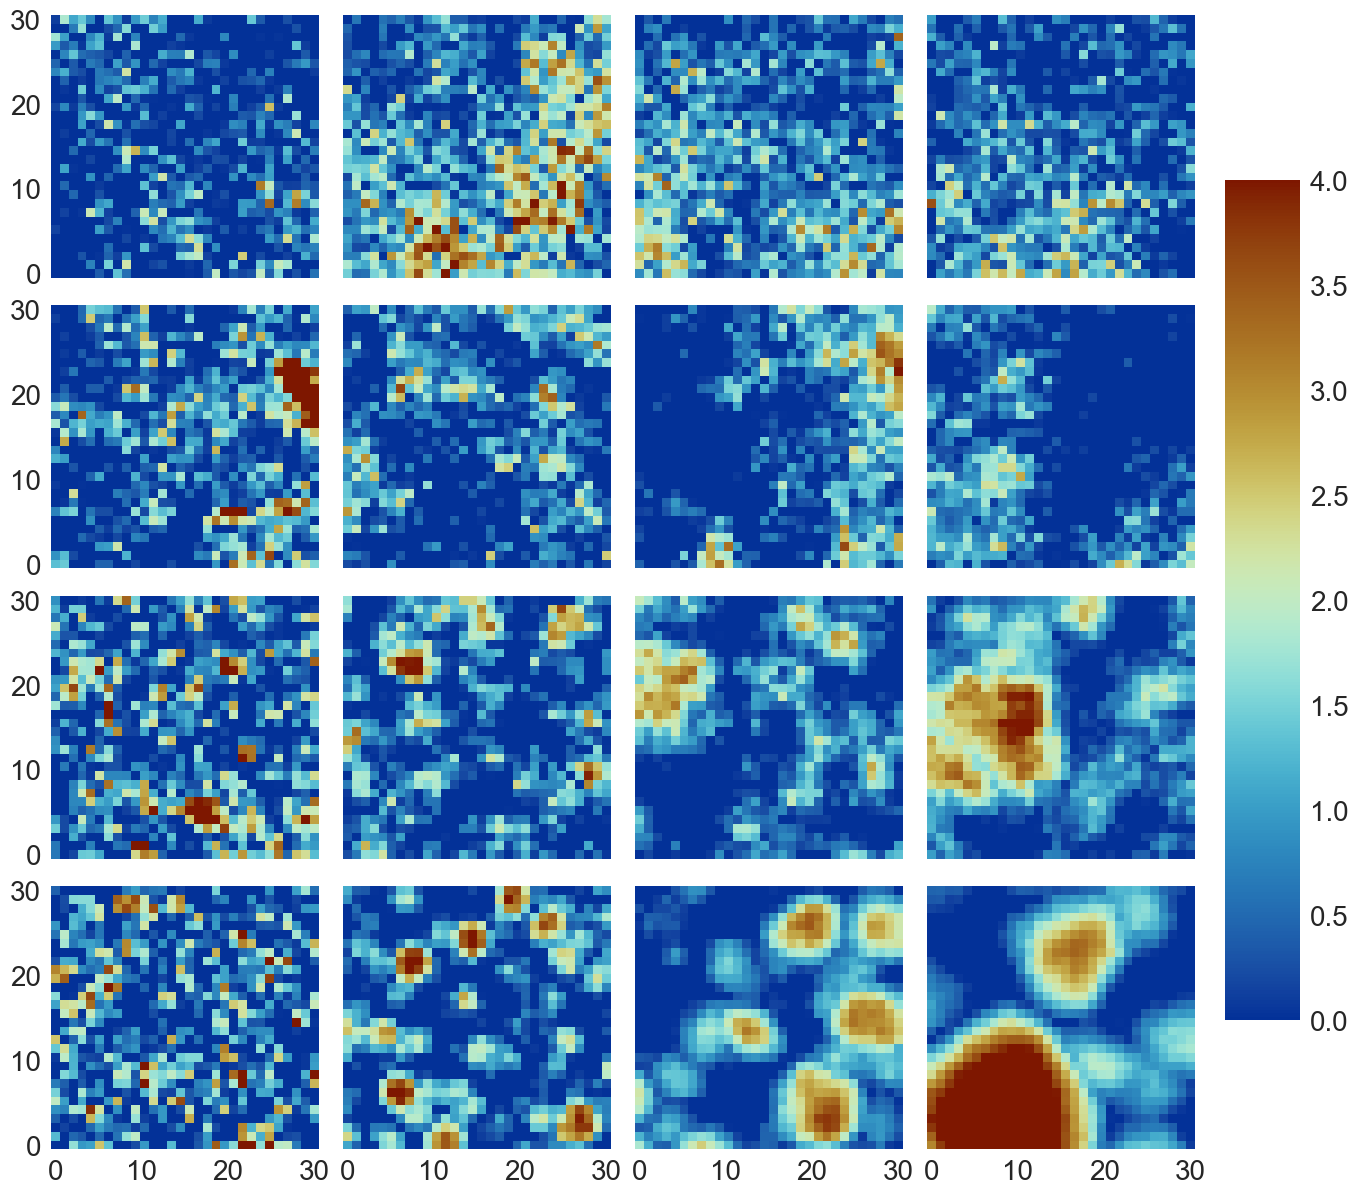

In [63]:
fig, axs = plt.subplots(4,4,figsize = (15,12))
axs = axs.ravel()
x = np.linspace(0,30,30)

#Define colormap
normalizer=Normalize(0,4)
im=cm.ScalarMappable(norm=normalizer)

for i in range(16):
    params = example_params[i]
    data_plot = np.log(example_data[:,:,i])
    axs[i].pcolormesh(x, x, data_plot,norm=normalizer)
    axs[i].tick_params(axis='both', which='major', labelsize=ticksize)
    axs[i].set_xticks(np.arange(0, 31, step=10))

    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=ticksize)

plt.savefig(path + f"{model}_example.png", bbox_inches = "tight")

In [96]:
model = "powexp"

example_params = pyreadr.read_r(plot_path+model+"_example_params.RData")["train_params"].to_numpy()
example_data = pyreadr.read_r(plot_path+model+"_example_data.RData")["train_data"].to_numpy()
example_data = np.reshape(example_data, newshape = (128, 128, -1))

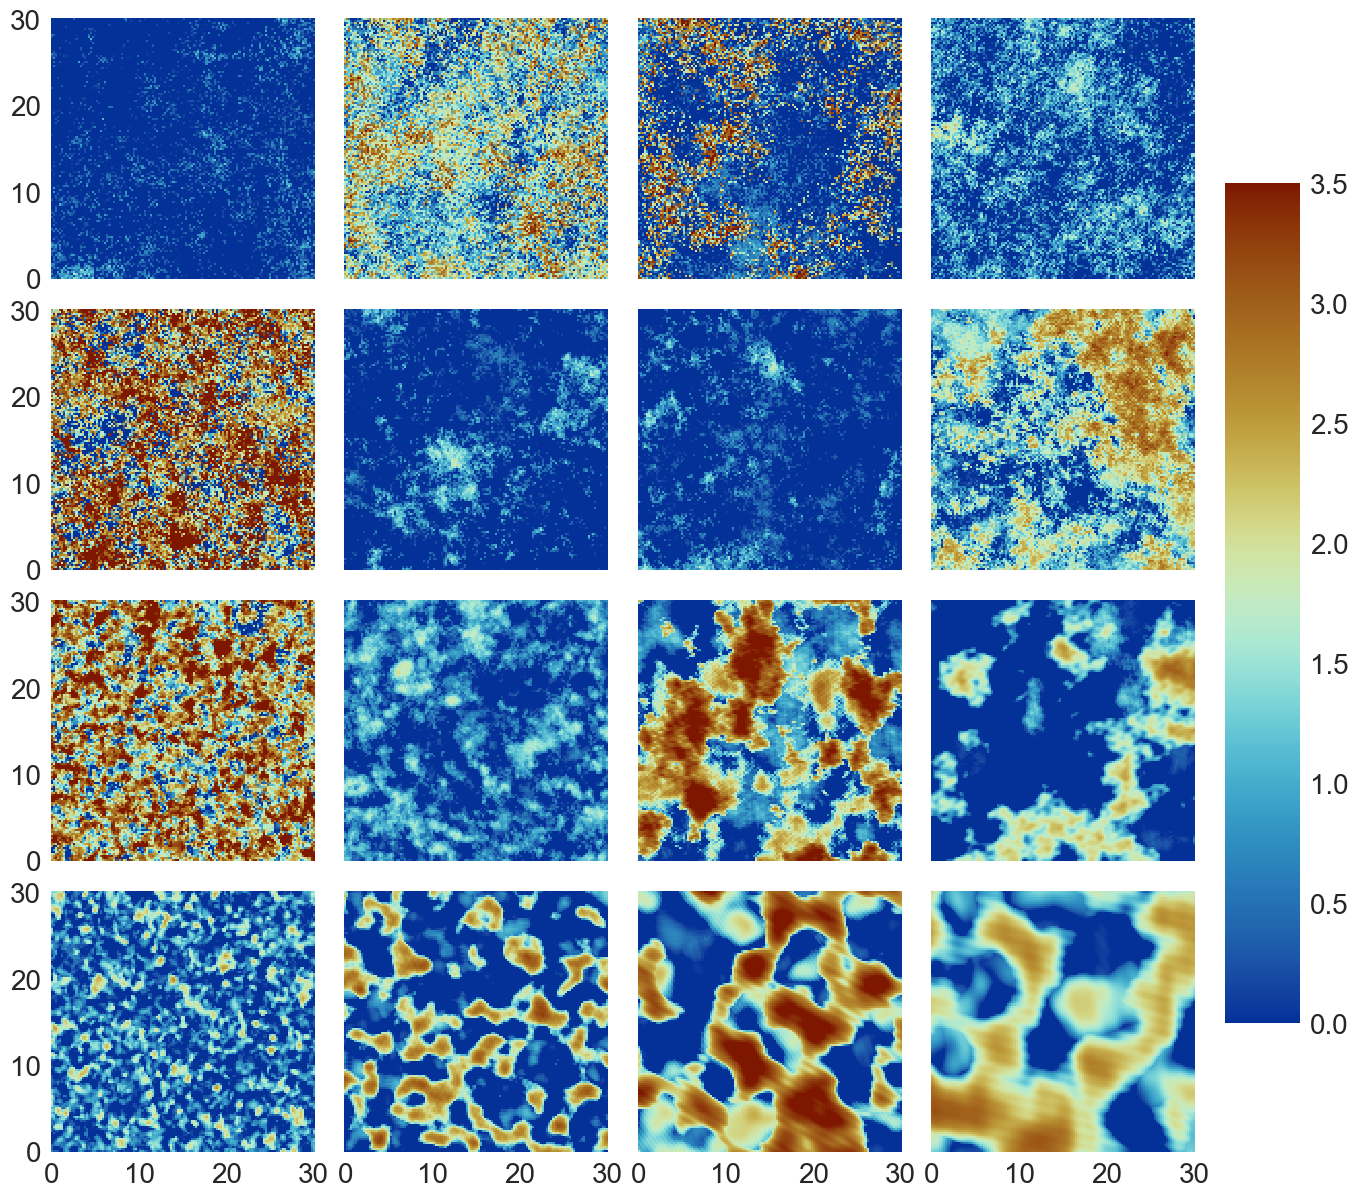

In [108]:
fig, axs = plt.subplots(4,4,figsize = (15,12))
axs = axs.ravel()
x = np.linspace(0,30,128)

#Define colormap
normalizer=Normalize(0,3.5)
im=cm.ScalarMappable(norm=normalizer)

for i in range(16):
    params = example_params[i]
    data_plot = np.log(example_data[:,:,i])
    axs[i].pcolormesh(x, x, data_plot, norm=normalizer)
    axs[i].tick_params(axis='both', which='major', labelsize=ticksize)
    axs[i].set_xticks(np.arange(0, 31, step=10))

    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=ticksize)

plt.savefig(path + f"{model}_example.png", bbox_inches = "tight")

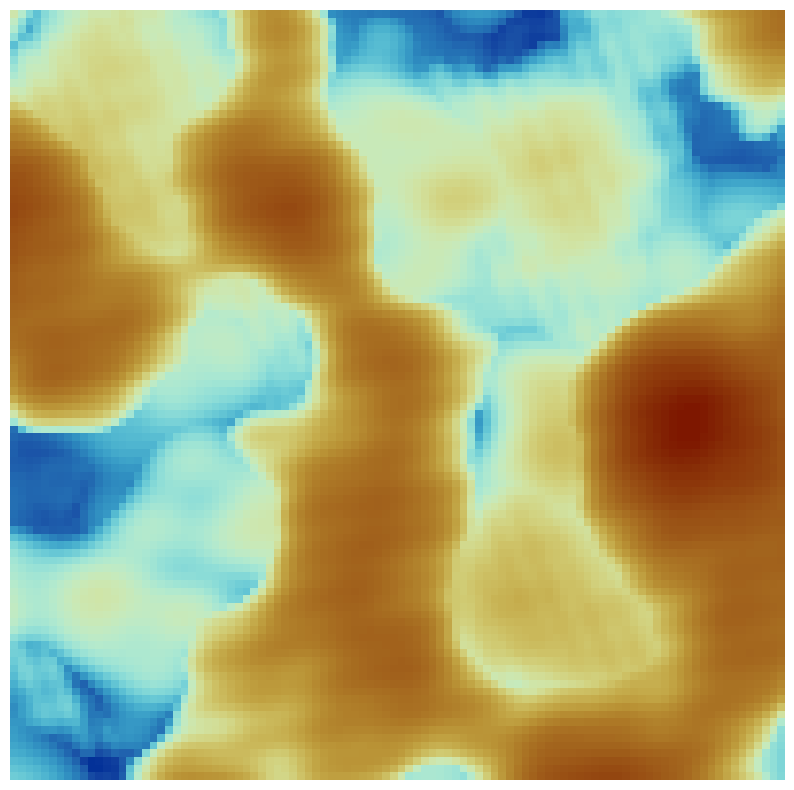

In [18]:
# Save single image
fig, axs = plt.subplots(figsize = (10,10))
x = np.linspace(0,10,100)


data_plot = np.log(example_data[:,:,14])
axs.pcolormesh(x, x, data_plot)

plt.axis('off')
#fig.savefig(path + 'max-stable-single_process.png', bbox_inches='tight', pad_inches=0)

# Plot quantile crossing example

In [26]:
def extremal_coefficient(h, r, s):
    corr = np.exp(-np.power((h/r),s))  
    res = 1+np.sqrt((1-corr)/2)        
    return res    

In [27]:
true_param = np.array([1.5,0.8])

r_sim = np.abs(np.random.normal(1.5, 0.7, 100))
s_sim = np.abs(np.random.normal(0.65, 0.25, 100))

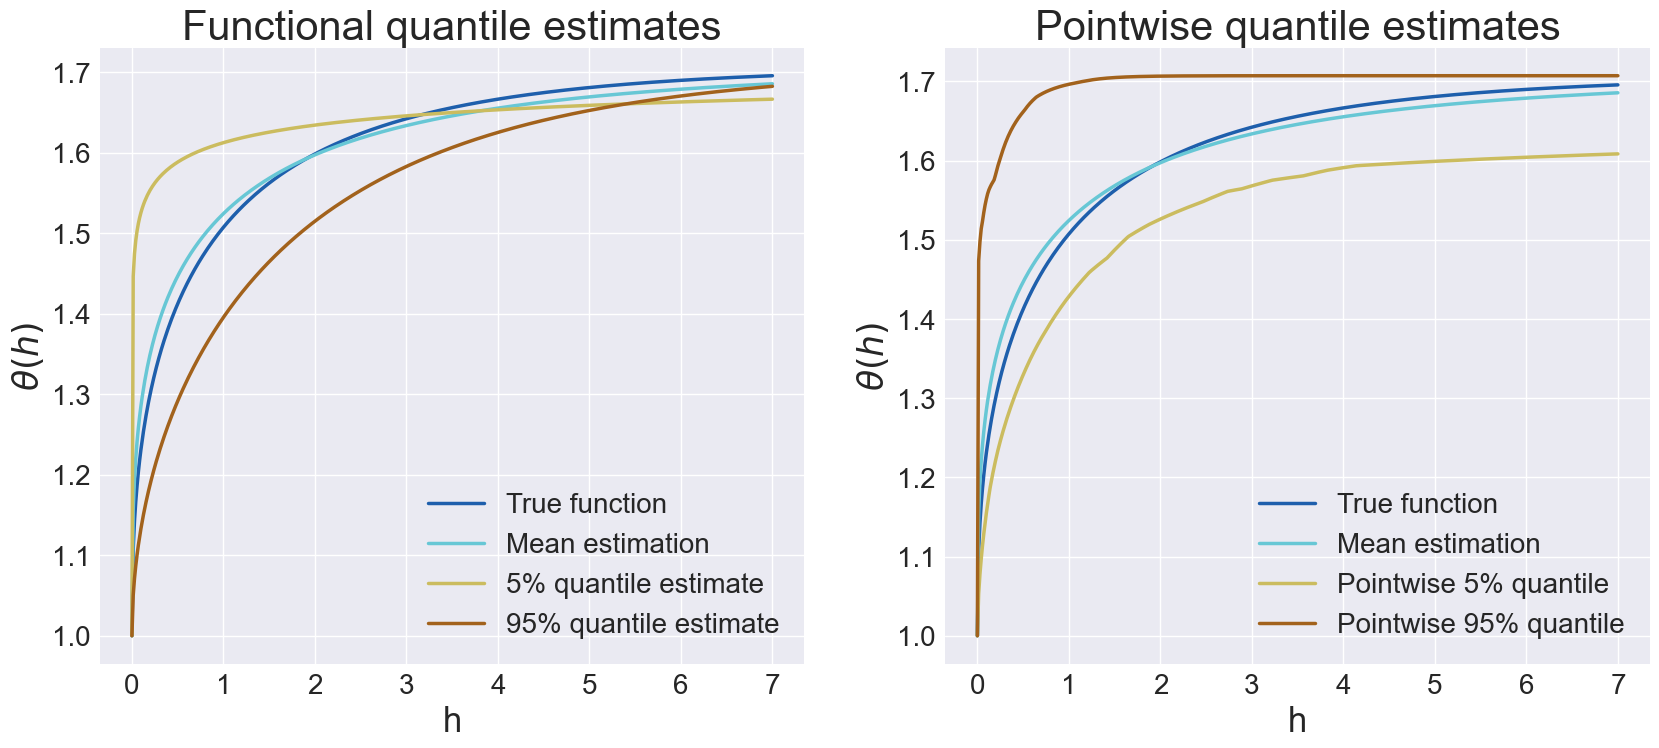

In [28]:
# Plot
h = np.linspace(0,7,500)

fig, axs = plt.subplots(1, 2, figsize = single_1)

y_true = extremal_coefficient(h, true_param[0], true_param[1])
y_mean = extremal_coefficient(h, r_sim.mean(), s_sim.mean())
y_lower = extremal_coefficient(h, np.quantile(r_sim, 0.05), np.quantile(s_sim, 0.05))
y_upper = extremal_coefficient(h, np.quantile(r_sim, 0.95), np.quantile(s_sim, 0.95))

#Plot quantile functions
axs[0].plot(h,y_true, label = "True function", color = cmap(0.1), lw = lw)
axs[0].plot(h,y_mean, label = "Mean estimation", color = cmap(0.35), lw = lw)
axs[0].plot(h,y_lower, label =  "5% quantile estimate", color = cmap(0.65), lw = lw)
axs[0].plot(h,y_upper, label = "95% quantile estimate", color = cmap(0.85), lw = lw)
axs[0].legend(loc = "best", fontsize = legendsize)
axs[0].set_xlabel("h", fontsize = axsize)
axs[0].set_ylabel(r"$\theta(h)$", fontsize = axsize)
axs[0].tick_params(axis='both', labelsize=ticksize)
axs[0].set_title("Functional quantile estimates", fontsize = titlesize)


#Pointwise
results = np.zeros(shape = (100, len(h)))
for j in range(100):
    results[j] = extremal_coefficient(h, r_sim[j], s_sim[j])
sample_upper = np.quantile(results, 0.975, axis = 0)
sample_lower = np.quantile(results, 0.025, axis = 0)

#Plot pointwise quantiles
axs[1].plot(h,y_true, label = "True function", color = cmap(0.1), lw = lw)
axs[1].plot(h,y_mean, label = "Mean estimation", color = cmap(0.35), lw = lw)
axs[1].plot(h,sample_lower, label =  "Pointwise 5% quantile", color = cmap(0.65), lw = lw)
axs[1].plot(h,sample_upper, label = "Pointwise 95% quantile", color = cmap(0.85), lw = lw)
axs[1].legend(loc = "best", fontsize = legendsize)
axs[1].set_xlabel("h", fontsize = axsize)
axs[1].set_ylabel(r"$\theta(h)$", fontsize = axsize)
axs[1].tick_params(axis='both', labelsize=ticksize)
axs[1].set_title("Pointwise quantile estimates", fontsize = titlesize)

plt.savefig(path +"quantile_crossing.pdf", bbox_inches = "tight")

# ABC example

In [7]:
parameters = np.array([0.5,1])
abc_single = pyreadr.read_r(plot_path+"abc_example_single.RData")["result"].to_numpy()
abc_multi = pyreadr.read_r(plot_path+"abc_example_several.RData")["result"].to_numpy()

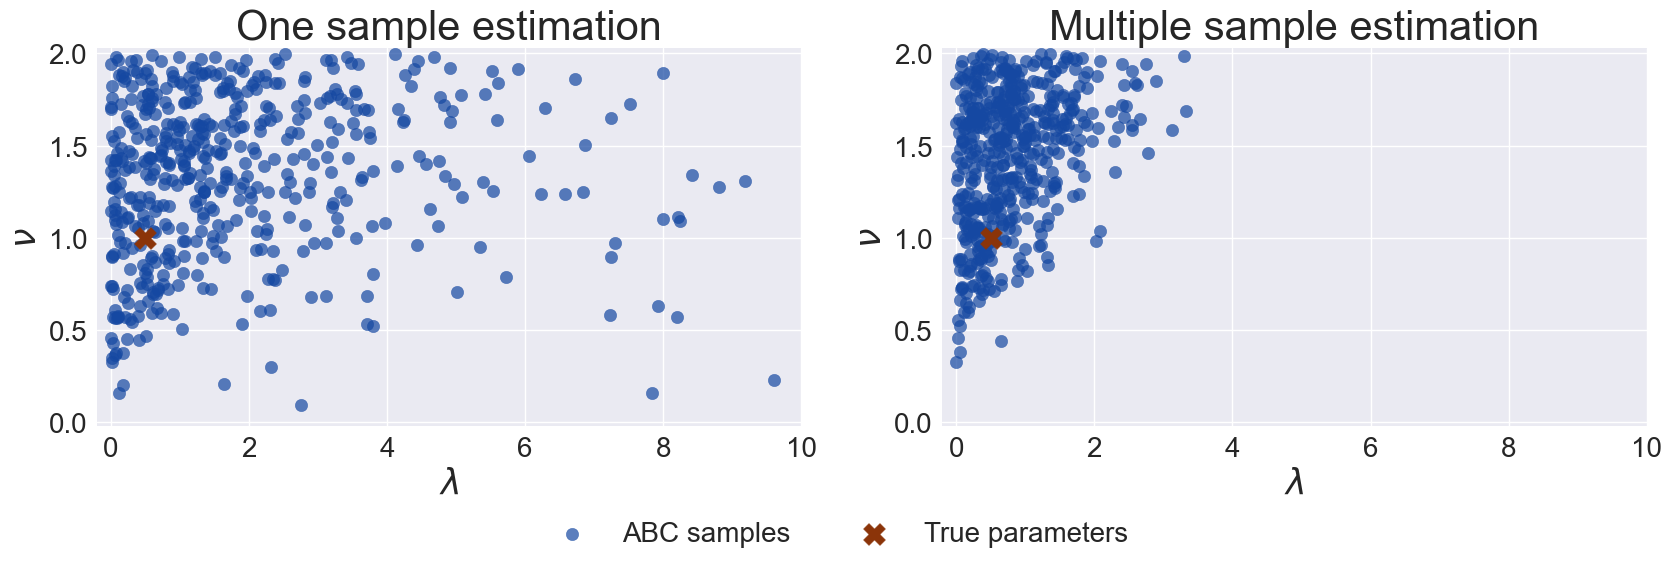

In [19]:
# Plot
fig, axs = plt.subplots(1, 2, figsize = (20,6))


#Plot abc single
axs[0].scatter(abc_single[:,0], abc_single[:,1], color = cmap(0.05), alpha = 0.7, s = 80)
#axs[0].scatter(abc_single[:,0].mean(), abc_single[:,1].mean(), marker = "X", color = cmap(0.95), s = 250)
axs[0].scatter(0.5, 1, color = cmap(0.95), s = 250, marker = "X")
axs[0].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[0].set_ylabel(r"$\nu$", fontsize = axsize)
axs[0].tick_params(axis='both', labelsize=ticksize)
axs[0].set_title("One sample estimation", fontsize = titlesize)
axs[0].set_xlim([-0.2,10])
axs[0].set_ylim([-0.02,2.03])


#Plot quantile functions
axs[1].scatter(abc_multi[:,0], abc_multi[:,1], color = cmap(0.05), alpha = 0.7, s = 80)
#axs[1].scatter(abc_multi[:,0].mean(), abc_multi[:,1].mean(), marker = "X", color = cmap(0.95), s = 250)
axs[1].scatter(0.5, 1, color = cmap(0.95), s = 250, marker = "X")
axs[1].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[1].set_ylabel(r"$\nu$", fontsize = axsize)
axs[1].tick_params(axis='both', labelsize=ticksize)
axs[1].set_title("Multiple sample estimation", fontsize = titlesize)
axs[1].set_xlim([-0.2,10])
axs[1].set_ylim([-0.02,2.03])

# Legend
fig.subplots_adjust(bottom=0.25)
fig.legend(labels = ["ABC samples", "True parameters"], loc='lower center', ncol = 3, fontsize = legendsize)

plt.savefig(path +"abc_example.pdf", bbox_inches = "tight")

# Results plot

## Normal results

In [24]:
exp = "normal"
data_path = f'../data/{exp}/data/'
results_path = f'../data/{exp}/results/'
# Define  length of test data
n_test = 250

In [47]:
#Load examples
model = "brown"

# Load true parameters
true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
# Load PL
pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
# Load ABC
abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
# Load normal network
cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

# Load energy network
cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]

#Get mean prediction
abc_mean = np.mean(abc, axis = 2)
cnn_es_mean = np.mean(cnn_es, axis = 2)

### Single plot

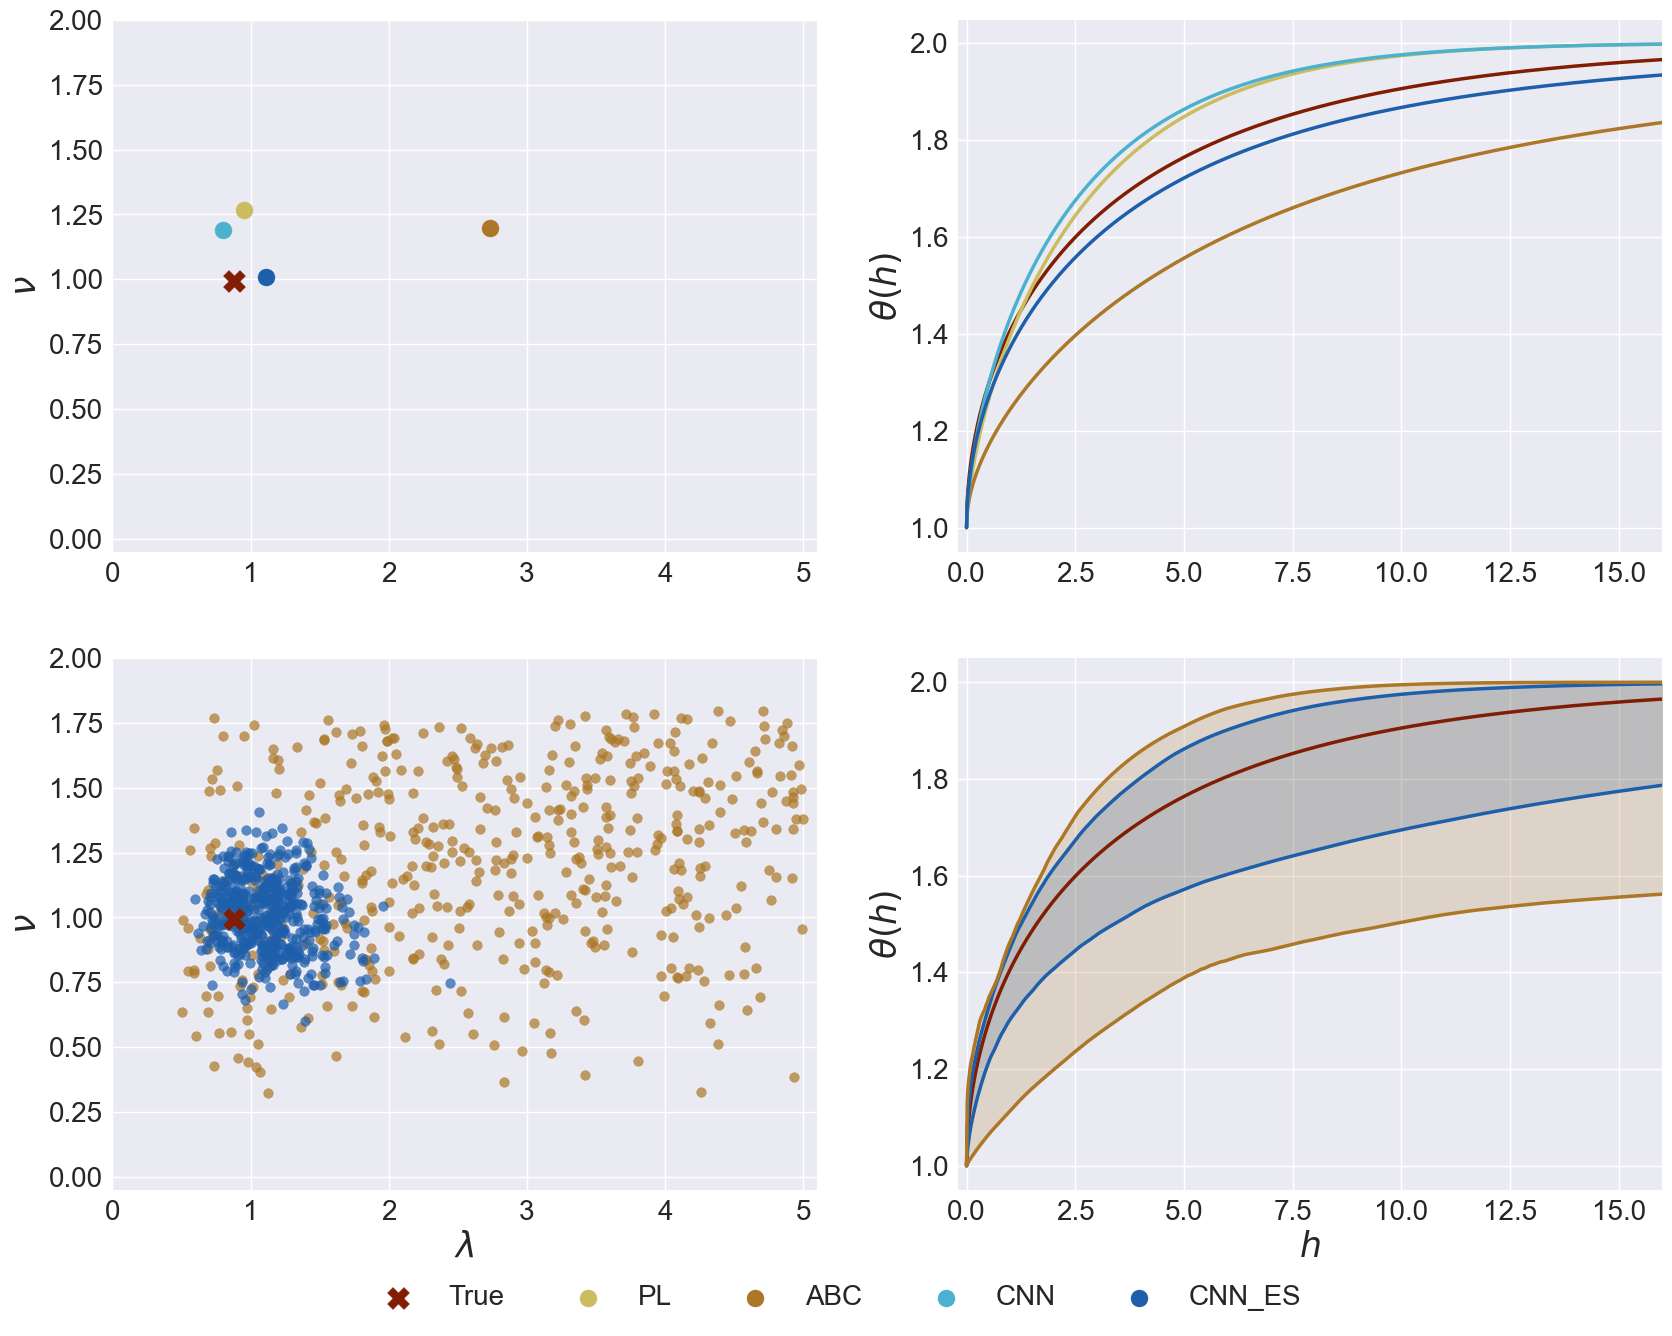

In [55]:
# Brown 49 Powexp 3
sample = 49

h = np.linspace(0,16,1000)
fig, axs = plt.subplots(2, 2, figsize = (20,15))
axs = np.transpose(axs).ravel()

#Mean values
axs[0].scatter(x = true_parameters[sample,0], y = true_parameters[sample,1], marker = "X", s = 250, color = cmap(0.99))
axs[0].scatter(x = pl[sample,0], y = pl[sample,1], color = cmap(0.65), s = 150)
axs[0].scatter(x = abc_mean[sample,0], y = abc_mean[sample,1], color = cmap(0.8), s = 150)
axs[0].scatter(x = cnn[sample,0], y = cnn[sample,1], color = cmap(0.3), s = 150)
axs[0].scatter(x = cnn_es_mean[sample,0], y = cnn_es_mean[sample,1], color = cmap(0.1), s = 150)
#axs[0].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[0].set_ylabel(r"$\nu$", fontsize = axsize)
axs[0].tick_params(axis='both', labelsize=ticksize)
axs[0].set_xlim([0,5.1])
axs[0].set_ylim([-0.05,2])


# Sample values
axs[1].scatter(x = abc[sample,0], y = abc[sample,1], alpha = 0.7, color = cmap(0.8))
axs[1].scatter(x = cnn_es[sample,0], y = cnn_es[sample,1], alpha = 0.7, color = cmap(0.1))
axs[1].scatter(x = true_parameters[sample,0], y = true_parameters[sample,1], marker = "X", s = 250, color = cmap(0.99))
axs[1].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[1].set_ylabel(r"$\nu$", fontsize = axsize)
axs[1].tick_params(axis='both', labelsize=ticksize)
axs[1].set_xlim([0,5.1])
axs[1].set_ylim([-0.05,2])


# Extremal coefficient
axs[2].plot(h, extremal_coefficient(h, model, true_parameters[sample,0], true_parameters[sample,1]), color = cmap(0.99), lw = 2.5)
axs[2].plot(h, extremal_coefficient(h, model, pl[sample,0], pl[sample,1]), color = cmap(0.65), lw = 2.5)
axs[2].plot(h, sample_extremal_coefficient(h, model, abc[sample,0], abc[sample,1]), color = cmap(0.8), lw = 2.5)
axs[2].plot(h, extremal_coefficient(h, model, cnn[sample,0], cnn[sample,1]), color = cmap(0.3), lw = 2.5)
axs[2].plot(h, sample_extremal_coefficient(h, model, cnn_es[sample,0], cnn_es[sample,1]), color = cmap(0.1), lw = 2.5)
#axs[2].set_xlabel(r"$h$", fontsize = axsize)
axs[2].set_ylabel(r"$\theta(h)$", fontsize = axsize)
axs[2].tick_params(axis='both', labelsize=ticksize)
axs[2].set_xlim([-0.2,16])

# Extremal coefficient uncertainty
es_quantiles = np.quantile(sample_extremal_coefficient(h, model, cnn_es[sample,0], cnn_es[sample,1],  mean = False), q = [0.025,0.975], axis = 0)
abc_quantiles = np.quantile(sample_extremal_coefficient(h, model, abc[sample,0], abc[sample,1],  mean = False), q = [0.025,0.975], axis = 0)

axs[3].plot(h, extremal_coefficient(h, model, true_parameters[sample,0], true_parameters[sample,1]), color = cmap(0.99), lw = 2.5)
axs[3].plot(h, es_quantiles[0], color = cmap(0.1), lw = 2.5)
axs[3].plot(h, es_quantiles[1], color = cmap(0.1), lw = 2.5)
axs[3].fill_between(h, es_quantiles[0], es_quantiles[1],  color = cmap(0.1), alpha=.2)

axs[3].plot(h, abc_quantiles[0], color = cmap(0.8), lw = 2.5)
axs[3].plot(h, abc_quantiles[1], color = cmap(0.8), lw = 2.5)
axs[3].fill_between(h, abc_quantiles[0], abc_quantiles[1], color = cmap(0.8), alpha=.2)
axs[3].set_xlabel(r"$h$", fontsize = axsize)
axs[3].set_ylabel(r"$\theta(h)$", fontsize = axsize)
axs[3].tick_params(axis='both', labelsize=ticksize)
axs[3].set_xlim([-0.2,16])


# Legend
fig.subplots_adjust(bottom=0.1)
fig.legend(labels = ["True", "PL", "ABC", "CNN", "CNN_ES"], loc='lower center', ncol = 5, fontsize = legendsize)

plt.savefig(path + f"normal_results_example_{model}_single.pdf", bbox_inches = "tight")